# Optimistic-GMBL

---

今回はこの[論文](https://arxiv.org/abs/2008.00311)で出てくるアルゴリズムを解説していきます．

上記の論文は制約付きMDPにおけるサンプル複雑度を分析している論文です．

ここではgenerative modelからのサンプルの取得が可能なことを仮定しています．

まず，前提知識の説明からしていきます．


---

### **前提知識**

制約付きMDPでは報酬とは別に環境に何らかの制約(障害物など)があり，それを評価するコスト関数があります．

シュミレーションする環境にはそれぞれ，コストの閾値があり，それを学習中に超えてはいけないという問題設定になります．

従来のMDPの問題の目的は報酬の最大化でしたが，制約付きMDPではコスト関数は閾値を超えずに，尚且つ報酬も最大化するということが目的となります．

下に有限ホライゾンの時の価値関数とコスト関数の定義を示します．

$$
V_t^\pi(s)=\mathbb{E}\left[\sum_{h=t}^{H-1} r\left(s_h, a_h\right) ; a_h \sim \pi\left(s_h, \cdot, h\right), s_t=s\right],
$$

$$
C_{i, t}^\pi(s)=\mathbb{E}\left[\sum_{h=t}^{H-1} c\left(i, s_h, a_h\right) ; a_t \sim \pi\left(s_h,,, h\right), s_t=s\right] .
$$

$r,c,\pi$は報酬関数，コスト関数，方策とします．

これらの定義を使い，有限ホライゾンでの問題設定は次のようになります．

$$
\max _\pi V_0^\pi\left(s_0\right) \text { s.t. } C_{i, 0}^\pi\left(s_0\right) \leq \bar{C}_i, \quad \forall i \in\{1, \ldots, N\}
$$

$\bar{C}_i$はi番目の試薬の閾値です．

この問題設定でのサンプル効率の定義は次のようになります．

$$
\begin{aligned}
\mathbb{P}\left(V_0^{\mathcal{A}}\left(s_0\right)\right. & \geq V_0^{\pi^*}\left(s_0\right)-\epsilon \text { and } \\
C_{i, 0}^{\mathcal{A}}\left(s_0\right) & \left.\leq \bar{C}_i+\epsilon \forall i \in\{1, \ldots, N\}\right) \geq 1-\delta
\end{aligned}
$$

従来のMDPとは違い，価値関数，制約関数のどちらも$\epsilon$-最適性を満たさなければいけない構造になっています．


---

### **GMBL**

GMBLのアルゴリズムでは遷移関数$P$を$\widehat{P}\left(s^{\prime} \mid s, a\right)=\frac{n\left(s^{\prime}, s, a\right)}{n(s, a)}$のようにに推定します．

n(s,a)は(s,a)の訪問回数とします．

この推定した遷移関数を用いて，新しいMDPを構築します．

$$
\begin{aligned}
& \mathcal{M}_k:=\left\{M^{\prime}: r^{\prime}(s, a)=r(s, a),\right. \\
& c^{\prime}(i, s, a)=c(i, s, a), H^{\prime}=H, s_0^{\prime}=s_0 \\
& \left|P^{\prime}\left(s^{\prime} \mid s, a\right)-\widehat{P}\left(s^{\prime} \mid s, a\right)\right| \leq \\
& \min \left(\sqrt{\frac{2 \widehat{P}\left(s^{\prime} \mid s, a\right)\left(1-\widehat{P}\left(s^{\prime} \mid s, a\right)\right)}{n(s, a)} \log \frac{4}{\delta_1}}\right. \\
& +\frac{2}{3 n(s, a)} \log \frac{4}{\delta_1}, \sqrt{\left.\left.\frac{\log 4 / \delta_1}{2 n(s, a)}\right) \forall s, s^{\prime}, a, i\right\},}
\end{aligned}
$$

このようなMDPをアルゴリズムの学習中に用いて，方策を導きます．

アルゴリズムは次のような方法になります．

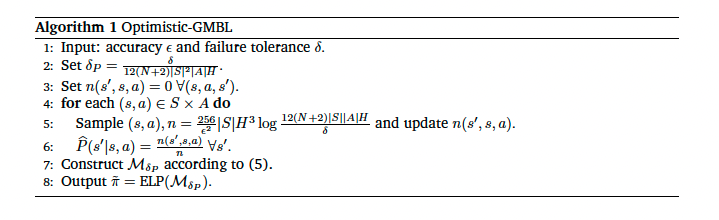

---

### **GMBLのコード**

In [ ]:
# 環境の構築

import numpy as np
import jax.numpy as jnp
from jax.random import PRNGKey
import jax
from typing import NamedTuple,Optional

key = PRNGKey(0)
S = 7 #状態空間
A = 3 #行動空間
S_set = jnp.arange(S)
A_set = jnp.arange(A)
gamma = 0.9 #割引率

#報酬と遷移確率の行列を作る．
key,_ = jax.random.split(key)
rew = jax.random.uniform(key,shape=(S,A))

key,_ = jax.random.split(key)
c_i = jax.random.uniform(key,shape=(S,A))
c_i = jnp.where(c_i>0.5,1,0)


C = 5.0
key,_ = jax.random.split(key)
P = np.random.rand(S*A,S)
P = P / P.sum(axis=-1,keepdims=True)
P = P.reshape(S,A,S)
np.testing.assert_allclose(P.sum(axis=-1),1.0)
P = jnp.array(P)

#MDPの作成
class MDP(NamedTuple):
    S_set: jnp.ndarray
    A_set: jnp.ndarray
    rew: jnp.ndarray #報酬
    P: jnp.ndarray #遷移確率
    gamma: float #割引率
    H:int #ホライゾン
    c_i: jnp.ndarray #制約コスト
    C : float #制約コストの上限
    optimal_Q:Optional[jnp.ndarray] = None

    @property
    def S(self):
        return len(self.S_set)
    
    @property
    def A(self):
        return len(self.A_set)
    

H = int(1/(1-gamma))
mdp = MDP(S_set,A_set,rew,P,gamma,H + 100,c_i,C)


In [2]:
from functools import partial
import chex

#制約を考えない時の最適価値関数の計算

@partial(jax.jit,static_argnames=('S','A'))
def _compute_optimal_Q(mdp:MDP,S:int,A:int):
    Q = jnp.zeros((S,A))
    def backup(Q):
        V = Q.max(axis=-1)
        return mdp.rew + mdp.gamma * mdp.P @ V
    body_fn = lambda i,Q:backup(Q)
    Q = jax.lax.fori_loop(0,mdp.H+100,body_fn,Q)
    return Q

compute_optimal_Q = lambda mdp: _compute_optimal_Q(mdp,mdp.S,mdp.A)
optimal_Q = compute_optimal_Q(mdp)
mdp = mdp._replace(optimal_Q=optimal_Q)


In [3]:
# greedy方策の計算
c_index = jnp.where(mdp.c_i==1)
index = [(c_index[0][i].item(),c_index[1][i].item()) for i in range(len(c_index[0]))]
@jax.jit
def get_greedy_con(mdp:MDP, q:jnp.array):
    S,A = mdp.S,mdp.A
    chex.assert_shape(q,(S,A))
    pi_max = jnp.zeros((S,A))
    for i in range(len(index)):
        q = q.at[index[i]].set(-np.inf)
    pi_max = pi_max.at[np.arange(S),q.argmax(axis=1)].set(1)

    return pi_max


In [4]:
# 制約を考えた時の最適価値関数
# 今回はviolationが0を想定している．
@partial(jax.jit,static_argnames=('S','A'))
def _compute_optimal_Q_constrained(mdp:MDP,S:int,A:int):
#制約がある状態行動対場所の確認
    Q = jnp.zeros((S,A))
    def backup(Q):
        policy = get_greedy_con(mdp,Q)
        return mdp.rew + mdp.gamma * mdp.P @ (policy * Q).sum(axis=-1)
    body_fn = lambda i,Q:backup(Q)
    Q = jax.lax.fori_loop(0,mdp.H+100,body_fn,Q)
    return Q
compute_optimal_Q_constrained = lambda mdp: _compute_optimal_Q_constrained(mdp,mdp.S,mdp.A)
optimal_Q_constrained = compute_optimal_Q_constrained(mdp)




In [5]:
print(f'最適価値関数と制約を考慮した最適価値関数の差:{(optimal_Q - optimal_Q_constrained).max()}')

最適価値関数と制約を考慮した最適価値関数の差:0.9998989105224609


### Optimistic-GMBL

In [6]:
import pulp

def Optimistic_GMBL(epsion:float,sigma:float,mdp:MDP):
    sigma_p = sigma / 36 * mdp.S**2 * mdp.A * mdp.H
    beta = np.sqrt(np.log(4)/2 * sigma_p)

    s_a_visit = 256*mdp.S*mdp.H**3/epsion**2*(np.log(36*mdp.S*mdp.A*mdp.H/sigma))
    s_a_visit = int(s_a_visit)
    transition_prob = np.zeros((mdp.S,mdp.A,mdp.S))
    for s in range(mdp.S):
        for a in range(mdp.A):
            s_dash = np.random.choice(a=mdp.S,size=s_a_visit,p=mdp.P[s,a])
            for i in range(mdp.S):
                transition_prob[s,a,i] = np.sum(s_dash==i)/s_a_visit
    
    opt_policy = np.zeros((mdp.S,mdp.H,mdp.A))
    #最大化問題の定義
    opt_problem = pulp.LpProblem('Optimistic_GMBL',pulp.LpMaximize)
    opt_q = np.zeros((mdp.H,mdp.S,mdp.A,mdp.S))
    #qの変数の定義
    q_keys = [(h,s,a,i) for h in range(mdp.H) for s in range(mdp.S) for a in range(mdp.A) for i in range(mdp.S)]
    q_vars = pulp.LpVariable.dicts('q',q_keys,lowBound=0,upBound=1,cat='Continuous')

    list_R = [mdp.rew[s][a] for s in range(mdp.S) for a in range(mdp.A)] * mdp.H
    list_q = [q_vars[(h,s,a,i)] for h in range(mdp.H) for s in range(mdp.S) for a in range(mdp.A) for i in range(mdp.S)] 
    #目的関数の定義
    opt_problem += pulp.lpDot(list_R,list_q)

    #制約条件の定義
    # for h in range(mdp.H):
    #     for s in range(mdp.S):
    #         for a in range(mdp.A):
    #             for i in range(mdp.S):
    #                 opt_problem += q_vars[(h,s,a,i)] * mdp.c_i[s][a] <= mdp.C
    #                 if h != 0:
    #                     opt_problem += q_vars[(h,s,a,i)] == q_vars[(h-1,i,a,s)]


    opt_problem += pulp.lpSum([q_vars[(h,s,a,i) * mdp.c_i[s][a]] for h in range(mdp.H) for s in range(mdp.S) for a in range(mdp.A) for i in range(mdp.S)]) <= mdp.C

    for h in range(1,mdp.H):
        opt_problem += pulp.lpSum([q_vars[(h,s,a,i)] for s in range(mdp.S) for a in range(mdp.A) for i in range(mdp.S)]) == pulp.lpSum([q_vars[(h-1,i,a,s)] for s in range(mdp.S) for a in range(mdp.A) for i in range(mdp.S)])

 
    opt_problem += pulp.lpSum([q_vars[(0,0,a,s)] for a in range(mdp.A) for s in range(mdp.S)]) == 1
    opt_problem += pulp.lpSum([q_vars[(0,s,a,s_dash)] for s in range(1,mdp.S) for a in range(mdp.A) for s_dash in range(mdp.S)]) == 0

    for h in range(1,mdp.H):
        for s in range(mdp.S):
            for a in range(mdp.A):
                for i in range(S):
                    opt_problem += q_vars[(h,s,a,i)] - (transition_prob[s,a,i] + beta) * pulp.lpSum([q_vars[(h,s,a,y)] for y in range(mdp.S)]) <= 0
                    opt_problem += -q_vars[(h,s,a,i)] + (transition_prob[s,a,i] - beta) * pulp.lpSum([q_vars[(h,s,a,y)] for y in range(mdp.S)]) <= 0      
    status = opt_problem.solve()

In [7]:
Optimistic_GMBL(0.1,0.1,mdp)

: 

: 